<a href="https://colab.research.google.com/github/sultanbst123/Zindi-Makerere-Fall-Armyworm-Crop-Challenge---ZindiAfrica/blob/main/Makerere_Fall_Armyworm_Crop_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Makerere Fall Armyworm Crop Challenge
</h1>

***Can you determine if maize crops have been affected by the fall armyworm pest?***

## Get a image file & import library

In [ ]:
#file library
import glob
import os 
import random
import gdown
from zipfile import ZipFile

# pre processing library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#deep learning library
import tensorflow as tf 
#import tensorflow_addons as tfa 
from tensorflow.keras import layers 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# check file 

os.listdir("/content/drive/MyDrive/Makerere Fall Armyworm Crop Challenge  ")

['Images.zip', 'Test.csv', 'Train.csv', 'SampleSubmission.csv']

In [ ]:
# unzip image to other file 


with ZipFile("/content/drive/MyDrive/Makerere Fall Armyworm Crop Challenge  /Images.zip", "r") as zipobj:
     zipobj.extractall("Makerere Fall Armyworm Crop images")

In [ ]:

# seed when training

def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

## Image Pre processing

In [ ]:

# buat config params

class CFG:
 
    #model params 
    DROPOUT = 0.1
    IMG_SIZE_1 = 128  
    IMG_SIZE_2 = 224
    BATCH_SIZE = 32
    AUTO = tf.data.experimental.AUTOTUNE
    CLASSES = 1

    # train params 
   
    INIT_RATE = 1e-4
    MAX_LR = 1e-2
    EPOCHS = 15   
    MOMENTUM = 0.9 # FOR SGD
    WEIGHT_DECAY = 1e-5
    LABEL_SMOOTHING = 0.1

In [ ]:
# read tabular file

df_train = pd.read_csv("/content/drive/MyDrive/Makerere Fall Armyworm Crop Challenge  /Train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Makerere Fall Armyworm Crop Challenge  /Test.csv")

In [ ]:
# check train file 

df_train

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1
...,...,...
1614,id_ztf4l3e8m6gmh.jpg,0
1615,id_ztgztu5vexsoe.jpg,1
1616,id_ztue0lrjt4l4g.jpg,0
1617,id_zyubro5pfg31d.jpg,0


In [ ]:
# check label distribution

df_train.Label.value_counts().to_frame().style.set_caption(" Distribution of label ")

,Label
0,810
1,809


In [ ]:

# buat path image nya 

df_train["path"] = "/content/Makerere Fall Armyworm Crop images/" + df_train["Image_id"]
df_test["path"] = "/content/Makerere Fall Armyworm Crop images/" + df_test["Image_id"]

In [ ]:
# helper function to show a random images

def show_img(data,label = True):
    random_img = np.random.choice(len(data), 15)

    plt.figure(figsize=(10, 10))
    for i in range(15):
        plt.subplot(5, 3, i+1)
        img = random_img[i]
        my_img = plt.imread(data.path[img])
        plt.imshow(my_img)
        if label: 
           plt.title(data.Label[img])
        plt.axis("off")
  
    plt.show()

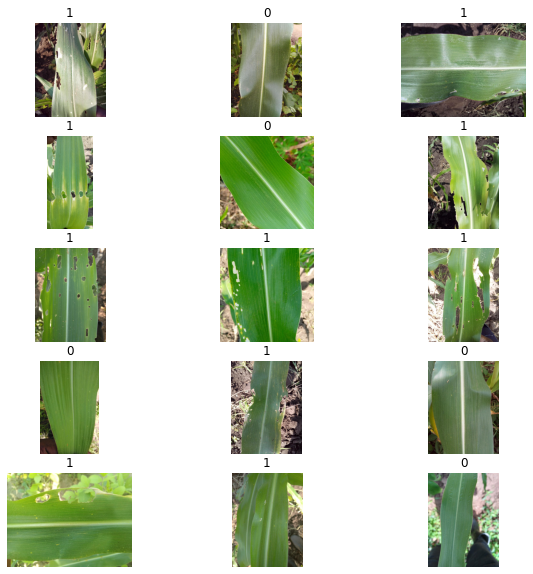

In [ ]:
# check random image train data 
show_img(df_train)

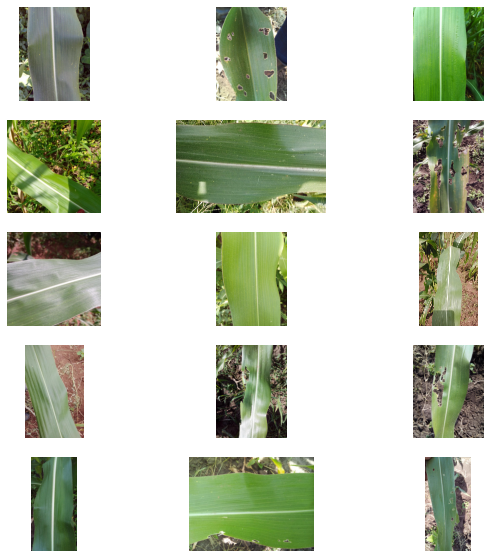

In [ ]:
# check random image test data 
show_img(df_test, label=False)

In [ ]:
# check target value

In [ ]:
df_train.Label.value_counts().to_frame().style.set_caption("Value Counts of Cultivar")

,Label
0,810
1,809


## Image Pre processing part 2

In [ ]:
# pisah kan label dan path gambar 

x = df_train.path
y = df_train.Label

new_test = df_test.path

In [ ]:

#split 95% train dan 5% validation

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.05, random_state=42)

In [ ]:

# helper function for read raw image to tf.Dataset


def img_read(is_labelled):
    def read_img(image_path):
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.cast(img, tf.uint8)
        img = tf.image.resize(img, (CFG.IMG_SIZE_2,CFG.IMG_SIZE_2))
        return img
    
    def can_be_readed(path, label):
        return read_img(path), label

    return can_be_readed if is_labelled else read_img

def creat_dataset_image(images, labels = None,is_labelled = True):
    # function to convert images 
    image_read = img_read(is_labelled)
    
    # creating dataset of image path and pawpularity score
    if is_labelled:
        input_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
        
        # converting images to tensors
        dataset = input_dataset.map(image_read, num_parallel_calls=CFG.AUTO)
        
        # spliting in batches
        dataset = dataset.shuffle(1000).batch(CFG.BATCH_SIZE).prefetch(CFG.AUTO)
        return dataset
        
    else :
        input_dataset_1 = tf.data.Dataset.from_tensor_slices((images))
        
        # converting images to tensors
        input_dataset_1 = input_dataset_1.map(image_read, num_parallel_calls=CFG.AUTO)
        dataset = input_dataset_1.batch(CFG.BATCH_SIZE).prefetch(CFG.AUTO)
        
        return dataset

In [ ]:

# store to new variable

train_dataset = creat_dataset_image(x_train,y_train)
val_dataset = creat_dataset_image(x_val,y_val)
test_dataset = creat_dataset_image(new_test,is_labelled = False)

In [ ]:

# check dataset pipeline

train_dataset, val_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>)

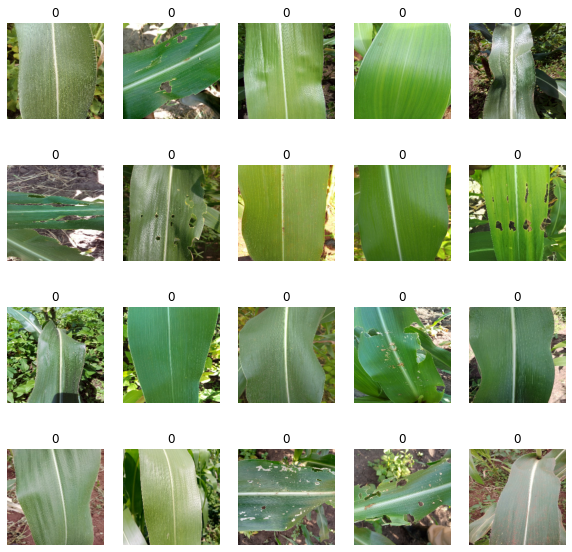

In [ ]:

# check random image 

image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for n in range(20):
    ax = plt.subplot(4,5, n + 1)
    plt.imshow(image_batch[n].numpy().astype("int")) 
    plt.title(np.argmax(label_batch[n].numpy()))
    plt.axis("off")

In [ ]:
#

## Image Augmentation 

Jika di perlukan!!!!

In [ ]:

# sedikit augmentation

simple_aug = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        #layers.RandomCrop(CFG.IMG_SIZE_1, CFG.IMG_SIZE_1), 
        #layers.RandomContrast(factor=0.9), 
    ],name="data_augmentation")

In [ ]:

# khusus data train saja

train_dataset_augmentation = train_dataset.map(lambda x, y: (simple_aug(x), y), num_parallel_calls=CFG.AUTO)

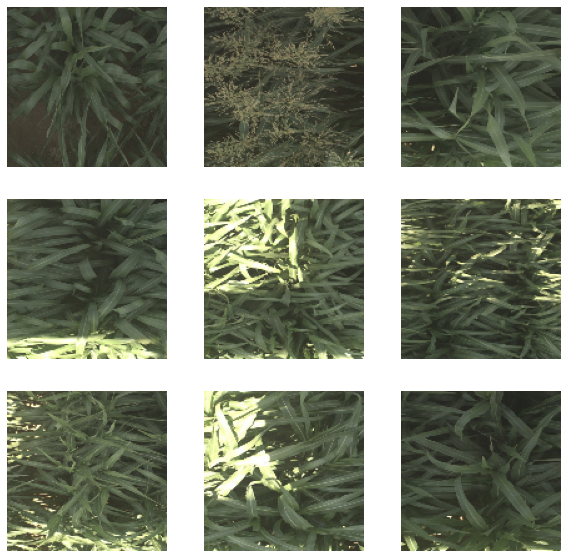

In [ ]:
# check image after augmentation

sample_images, _ = next(iter(tryu))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## Modelling

In [ ]:

# install pretrained model and tensorflow_addons

!pip install tfimm
!pip install timm
!pip install tensorflow_addons

In [ ]:
import tfimm
import tensorflow_addons as tfa

In [ ]:

# check all pre trained models

for i in tfimm.list_models(pretrained="timm"): 
    print(i)

cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
convmixer_768_32
convmixer_1024_20_ks9_p14
convmixer_1536_20
convnext_base
convnext_base_384_in22ft1k
convnext_base_in22ft1k
convnext_base_in22k
convnext_large
convnext_large_384_in22ft1k
convnext_large_in22ft1k
convnext_large_in22k
convnext_small
convnext_small_384_in22ft1k
convnext_small_in22ft1k
convnext_small_in22k
convnext_tiny
convnext_tiny_384_in22ft1k
convnext_tiny_in22ft1k
convnext_tiny_in22k
convnext_xlarge_384_in22ft1k
convnext_xlarge_in22ft1k
convnext_xlarge_in22k
deit_base_distilled_patch16_224
deit_base_distilled_patch16_384
deit_base_patch16_224
deit_base_patch16_384
deit_small_distilled_patch16_224
deit_small_patch16_224
deit_tiny_distilled_patch16_224
deit_tiny_patch16_224
ecaresnet26t
ecaresnet50d
ecaresnet50t
ecaresnet101d
ecaresnet269d
ecaresnetlight
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4


In [ ]:
# defime optimizer algorithm

In [ ]:

#pakai adamW sebagai algoritma pengoptimalan 

ADAMW = tfa.optimizers.AdamW(learning_rate = CFG.INIT_RATE, weight_decay = CFG.WEIGHT_DECAY)

In [ ]:
input = layers.Input(shape=(CFG.IMG_SIZE_2, CFG.IMG_SIZE_2, 3))

# make a input pre processing for raw image
x = tfimm.create_preprocessing("deit_small_distilled_patch16_224", dtype="float32")(input)

# swim & deit model
deit = tfimm.create_model("deit_small_distilled_patch16_224", nb_classes=0, pretrained="timm")(x) 
  
# add fc      
x1 = layers.GlobalAveragePooling1D()(swin)
x1 = layers.Dropout(0.2)(x1)
output = layers.Dense(1, activation="sigmoid")(x1)

model = tf.keras.Model(inputs=input, outputs=output)


# freeze pre trained model 
for layer in model.layers[5:6]:
    layer.trainable = False

#compile model 
model.compile(optimizer = ADAMW,
              loss = tf.keras.losses.BinaryCrossentropy(),#(label_smoothing = 0.1), # tambahkan label_smoothing karena overfit 
              metrics = [tf.keras.metrics.AUC(),"acc"]) # fokus auc metrics

model.summary()

All PyTorch model weights were used when initializing ViT.
All the weights of ViT were initialized from the PyTorch model.



Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_6 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                           

In [ ]:
set_seed() # seed everything

# only save best epoch
cp_path = "/tmp/checkpoint"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_dataset, validation_data=val_dataset, 
                    epochs=CFG.EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/15
49/49 [==============================] - 33s 350ms/step - loss: 1.3645 - auc: 0.3295 - acc: 0.3882 - val_loss: 0.7805 - val_auc: 0.5783 - val_acc: 0.5309
Epoch 2/15
49/49 [==============================] - 14s 198ms/step - loss: 0.6881 - auc: 0.7096 - acc: 0.6612 - val_loss: 0.4790 - val_auc: 0.8442 - val_acc: 0.7901
Epoch 3/15
49/49 [==============================] - 14s 201ms/step - loss: 0.4945 - auc: 0.8425 - acc: 0.7627 - val_loss: 0.3602 - val_auc: 0.9263 - val_acc: 0.8272
Epoch 4/15
49/49 [==============================] - 14s 199ms/step - loss: 0.3873 - auc: 0.9069 - acc: 0.8212 - val_loss: 0.2932 - val_auc: 0.9614 - val_acc: 0.8642
Epoch 5/15
49/49 [==============================] - 14s 204ms/step - loss: 0.3217 - auc: 0.9397 - acc: 0.8563 - val_loss: 0.2469 - val_auc: 0.9801 - val_acc: 0.9012
Epoch 6/15
49/49 [==============================] - 16s 233ms/step - loss: 0.2775 - auc: 0.9558 - acc: 0.8901 - val_loss: 0.2171 - val_auc: 0.9905 - val_acc: 0.9383
Epoch 7/15

In [ ]:

# check best metrics evaluation

loss, accuracy = model.evaluate(val_dataset)
print(f"loss : {loss}") 
print(f"val accuracy : {round(accuracy * 100, 2)}%")

3/3 [==============================] - 1s 147ms/step - loss: 0.1176 - acc: 0.9877
loss : 0.1175803542137146
val accuracy : 98.77%


In [ ]:
# predict validation data 

y_true = model.predict(val_dataset)

## Metrics Monitoring

In [ ]:
scoring = pd.DataFrame()

In [ ]:
model = ["swin_base_patch4_window7_224_in22k", 
"swin_large_patch4_window7_224_in22k", 
"deit_base_distilled_patch16_224", 
"deit_small_distilled_patch16_224"]

accuracy_train = [0.9421,0.9883, 0.9837,0.9408]
accuracy_validation = [98.77,98.77, 100.0,0.9877]
loss_train = [0.2144,0.0910, 0.0820,0.1621]
loss_validation = [0.1668,0.0911, 0.0599,0.1176]

Augmented = ["No","No", "No", "No"]

In [ ]:
hasil_predict = pd.DataFrame()
hasil_predict["model"] = model
hasil_predict["accuracy_train"] = accuracy_train
hasil_predict["accuracy_validation"] = accuracy_validation
hasil_predict["loss_train"] = loss_train
hasil_predict["loss_validation"] = loss_validation
hasil_predict["Augmented"] = Augmented

In [ ]:
hasil_predict

,model,accuracy_train,accuracy_validation,loss_train,loss_validation,Augmented
0,swin_base_patch4_window7_224_in22k,0.9421,98.7700,0.2144,0.1668,No
1,swin_large_patch4_window7_224_in22k,0.9883,98.7700,0.0910,0.0911,No
2,deit_base_distilled_patch16_224,0.9837,100.0000,0.0820,0.0599,No
3,deit_small_distilled_patch16_224,0.9408,0.9877,0.1621,0.1176,No


## Submission

In [ ]:

# make a prediction 

y_asli = model.predict(test_dataset)

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/Makerere Fall Armyworm Crop Challenge  /SampleSubmission.csv")

In [ ]:
y_asli

array([[0.2589835 ],
       [0.01743945],
       [0.99082476],
       ...,
       [0.02896212],
       [0.9803627 ],
       [0.95742756]], dtype=float32)

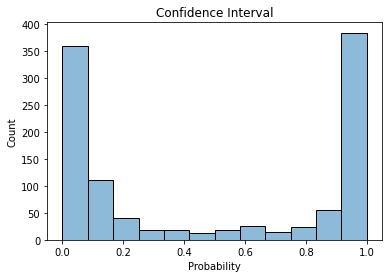

In [ ]:

# liat distribution nya

sns.histplot(y_asli)
plt.title("Confidence Interval")
plt.xlabel("Probability")
plt.legend([],[], frameon=False)

In [ ]:

#store score to label 

submission["Label"] = y_asli

In [ ]:
submission

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0.258983
1,id_03dqinf6w0znv.jpg,0.017439
2,id_046yl0cxn3ybz.jpg,0.990825
3,id_04athdtx2abyg.jpg,0.071657
4,id_062aauf9e9jk0.jpg,0.181127
...,...,...
1075,id_zv5fvjnakvf1r.jpg,0.980877
1076,id_zvpikh1z30arn.jpg,0.010301
1077,id_zypilwkudljyz.jpg,0.028962
1078,id_zz9lwehh5sxdp.jpg,0.980363


In [ ]:

# new file for submission

submission.to_csv("sub_ujicoba_5.csv", index=False)

## Ensemble Special Submission

In [ ]:
all_score = pd.DataFrame()

In [ ]:

#read all predictions values

score_5 = pd.read_csv("/content/sub_ujicoba_5.csv")
score_4 = pd.read_csv("/content/sub_ujicoba_4.csv")
score_3 = pd.read_csv("/content/sub_ujicoba_3.csv")
score_2 = pd.read_csv("/content/sub_ujicoba_2.csv")

In [ ]:


all_score["Image_id"] = score_5.Image_id
all_score["score_5"] = score_5.Label
all_score["score_4"] = score_4.Label
all_score["score_3"] = score_3.Label
all_score["score_2"] = score_2.Label

In [ ]:
all_score

,Image_id,score_5,score_4,score_3,score_2
0,id_00exusbkgzw1b.jpg,0.258983,0.231162,0.096737,0.256301
1,id_03dqinf6w0znv.jpg,0.017439,0.018158,0.086018,0.239393
2,id_046yl0cxn3ybz.jpg,0.990825,0.999103,0.999310,0.991387
3,id_04athdtx2abyg.jpg,0.071657,0.030343,0.045732,0.082211
4,id_062aauf9e9jk0.jpg,0.181127,0.047381,0.028548,0.043000
...,...,...,...,...,...
1075,id_zv5fvjnakvf1r.jpg,0.980877,0.980994,0.989225,0.962980
1076,id_zvpikh1z30arn.jpg,0.010301,0.003020,0.038138,0.132339
1077,id_zypilwkudljyz.jpg,0.028962,0.008342,0.016119,0.039815
1078,id_zz9lwehh5sxdp.jpg,0.980363,0.961682,0.669494,0.654685


In [ ]:
# rata ratakan semua score untuk ensemble

all_score["ensemble"] = all_score.iloc[:,1:].mean(axis=1)

In [ ]:
all_score

,Image_id,score_5,score_4,score_3,score_2,ensemble
0,id_00exusbkgzw1b.jpg,0.258983,0.231162,0.096737,0.256301,0.210796
1,id_03dqinf6w0znv.jpg,0.017439,0.018158,0.086018,0.239393,0.090252
2,id_046yl0cxn3ybz.jpg,0.990825,0.999103,0.999310,0.991387,0.995156
3,id_04athdtx2abyg.jpg,0.071657,0.030343,0.045732,0.082211,0.057486
4,id_062aauf9e9jk0.jpg,0.181127,0.047381,0.028548,0.043000,0.075014
...,...,...,...,...,...,...
1075,id_zv5fvjnakvf1r.jpg,0.980877,0.980994,0.989225,0.962980,0.978519
1076,id_zvpikh1z30arn.jpg,0.010301,0.003020,0.038138,0.132339,0.045950
1077,id_zypilwkudljyz.jpg,0.028962,0.008342,0.016119,0.039815,0.023310
1078,id_zz9lwehh5sxdp.jpg,0.980363,0.961682,0.669494,0.654685,0.816556


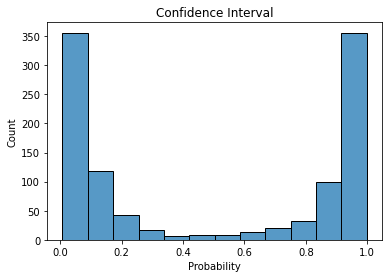

In [ ]:


# liat distribution hasil ensemble

sns.histplot(all_score["ensemble"])
plt.title("Confidence Interval")
plt.xlabel("Probability")
plt.legend([],[], frameon=False)

In [ ]:
# make new submission

all_score[["Image_id","ensemble"]].to_csv("sub_nya.csv", index=False)

##  End